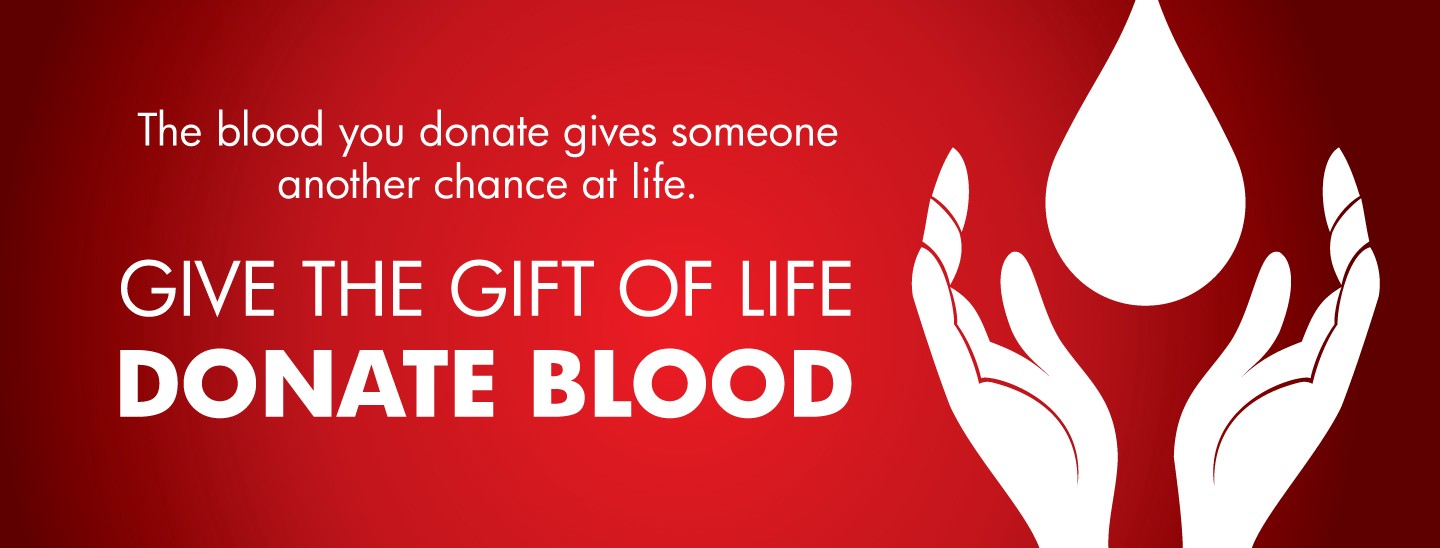

# Predict Blood Donation for Future Expectancy

### Introduction
Blood donation has been around for a long time. The first successful recorded transfusion was between two dogs in 1665, and the first medical use of human blood in a transfusion occurred in 1818. Even today, donated blood remains a critical resource during emergencies.

Our dataset is collected from the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes its blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. The dataset, obtained from the UCI Machine Learning Repository, consists of a random sample of 748 donors. 

### Problem Statement
We want to predict whether or not a donor will give blood the next time or not. Full model-building process: from inspecting the dataset to using the tpot library to automate your Machine Learning pipeline.

### Project Tasks
 - Inspecting transfusion.data file
 - Loading the blood donations data
 - Inspecting transfusion DataFrame
 - Creating target column
 - Checking target incidence
 - Splitting transfusion into train and test datasets
 - Selecting model using TPOT
 - Checking the variance
 - Log normalization
 - Training the linear regression model
 - Conclusion

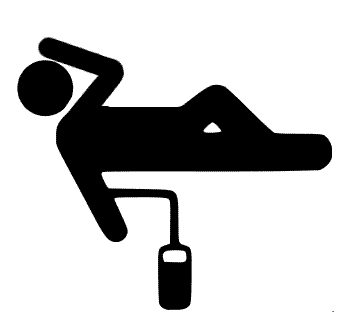

### Loading the blood donations data

In [1]:
# Filtering out the warnings
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Importing the required libraries

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
filepath = "C:\\Users\\HP\\Downloads\\transfusion\\transfusion.data"

# above .data file is comma delimited

df = pd.read_csv(filepath, delimiter=",")
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


### Inspecting transfusion DataFrame
Let's briefly return to our discussion of RFM model. RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In our case, our customers are blood donors.

###### RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:
 - R (Recency - months since the last donation)
 - F (Frequency - total number of donation)
 - M (Monetary - total blood donated in c.c.)
 - T (Time - months since the first donation)

a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)

It looks like every column in our DataFrame has the numeric type, which is exactly what we want when building a machine learning model. Let's verify our hypothesis.

In [4]:
# concise summary of transfusion DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [5]:
print("Rows : ", df.shape[0],"\n")
print("Columns : ", df.shape[1])

Rows :  748 

Columns :  5


In [6]:
df.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


### Creating target column

In [7]:
# Rename columns 'whether he/she donated blood in March 2007
# as'target' column 

df.rename(columns={'whether he/she donated blood in March 2007': 'target'},inplace=True)

df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


### Check for Data Imbalance

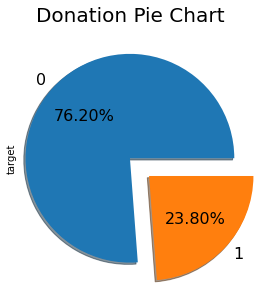

In [8]:
explode = [0,0.3] # To slice the perticuler section
textprops = {"fontsize":16} # Font size of text in pie chart

plt.title("Donation Pie Chart\n",{"fontsize":20})

df.target.value_counts(normalize=True).plot.pie(autopct = "%0.2f%%",explode = explode,textprops=textprops, shadow = True,radius = 1.2)

 
plt.show() # To show pie chart only

Observations :
 -  The number of negative responses is much higher than the number of positive responses.
 - Imbalance Dataset

### Data Exploration

In [9]:
res = df[["Recency (months)","Frequency (times)","Monetary (c.c. blood)","Time (months)","target"]].corr(method = 'pearson')
res

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
Recency (months),1.000000,-0.182745,-0.182745,0.160618,-0.279869
Frequency (times),-0.182745,1.000000,1.000000,0.634940,0.218633
Monetary (c.c. blood),-0.182745,1.000000,1.000000,0.634940,0.218633
Time (months),0.160618,0.634940,0.634940,1.000000,-0.035854
target,-0.279869,0.218633,0.218633,-0.035854,1.000000


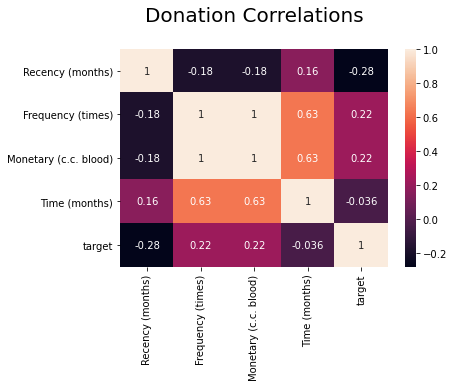

In [10]:
plt.title("Donation Correlations\n",{"fontsize":20})
sns.heatmap(res, annot=True)
plt.show()

Observations :
 -  Positive Correlation
      - Increase in one feature will increase other feature.
 - Negative Correlation
      - Increase in one feature will decrease the other feature
      
 - We focus on which features have strong positive or negative correlation with Target Column

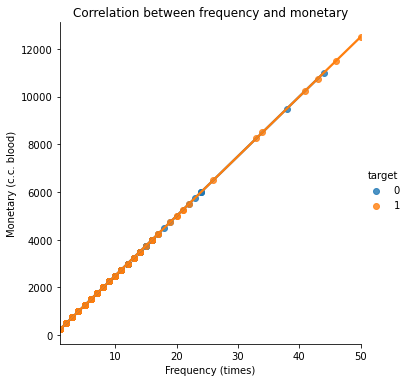

In [11]:
sns.lmplot(data=df,x='Frequency (times)',y='Monetary (c.c. blood)',hue='target')
plt.title("Correlation between frequency and monetary")

plt.show()

**Frequency and monetary values are highly correlated.**

##### Handling Outliers

In [12]:
df["Recency (months)"].describe()

count    748.000000
mean       9.506684
std        8.095396
min        0.000000
25%        2.750000
50%        7.000000
75%       14.000000
max       74.000000
Name: Recency (months), dtype: float64

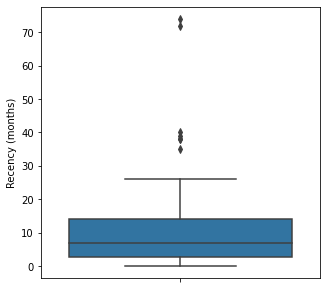

In [13]:
# checking outlier for 'Months Since Last Donation'
plt.figure(figsize=[5,5])
sns.boxplot(data=df,y="Recency (months)")
plt.show()

In [14]:
df["Recency (months)"].quantile([0.5,0.7,0.9,0.95,0.99])

0.50     7.00
0.70    14.00
0.90    21.00
0.95    23.00
0.99    25.53
Name: Recency (months), dtype: float64

In [15]:
# Boxplot is showing the outliers for recency, there are few entries having very large Recency than others.
# Considering this entries will mislead the further analysis.

# Excluding values outside 99 percentile for Recency

df = df[df['Recency (months)'] < np.nanpercentile(df['Recency (months)'], 99)]

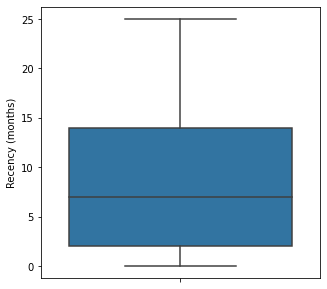

In [16]:
# checking outlier for 'Months Since Last Donation'
plt.figure(figsize=[5,5])
sns.boxplot(data=df,y="Recency (months)")
plt.show()

**Months since Last Donation** - happened between 5th and 10th month

In [17]:
df["Frequency (times)"].describe()

count    740.000000
mean       5.555405
std        5.855815
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       50.000000
Name: Frequency (times), dtype: float64

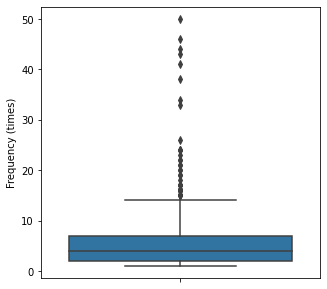

In [18]:
# checking outlier for 'total number of donation'
plt.figure(figsize=[5,5])
sns.boxplot(data=df,y="Frequency (times)")
plt.show()

In [19]:
df["Frequency (times)"].quantile([0.5,0.7,0.9,0.95,0.99])

0.50     4.00
0.70     6.00
0.90    12.00
0.95    16.00
0.99    30.27
Name: Frequency (times), dtype: float64

In [20]:
# Boxplot is showing the outliers for frequency, there are few entries having very large Frequency than others.
# Considering this entries will mislead the further analysis.

# Excluding values outside 99 percentile for Frequency

df = df[df['Frequency (times)'] < np.nanpercentile(df['Frequency (times)'], 99)]

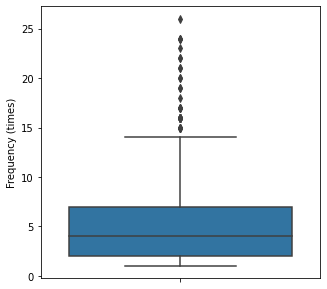

In [21]:
# checking outlier for 'total number of donation'
plt.figure(figsize=[5,5])
sns.boxplot(data=df,y="Frequency (times)")
plt.show()

**Total Number of Donations** - approx. 5 times

In [22]:
df["Monetary (c.c. blood)"].describe()

count     732.000000
mean     1291.666667
std      1127.464115
min       250.000000
25%       500.000000
50%      1000.000000
75%      1750.000000
max      6500.000000
Name: Monetary (c.c. blood), dtype: float64

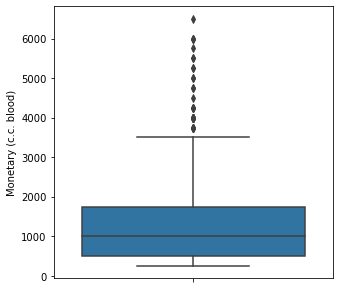

In [23]:
# checking outlier for 'total blood donated in c.c'
plt.figure(figsize=[5,5])
sns.boxplot(data=df,y="Monetary (c.c. blood)")
plt.show()

In [24]:
df["Monetary (c.c. blood)"].quantile([0.5,0.7,0.9,0.95,0.99])

0.50    1000.0
0.70    1500.0
0.90    2750.0
0.95    3612.5
0.99    5250.0
Name: Monetary (c.c. blood), dtype: float64

In [25]:
# months since the first donation
df["Time (months)"].describe()

count    732.000000
mean      33.439891
std       23.692177
min        2.000000
25%       16.000000
50%       28.000000
75%       48.000000
max       98.000000
Name: Time (months), dtype: float64

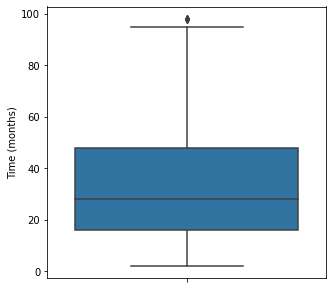

In [26]:
# checking outlier for 'months since the first donation'
plt.figure(figsize=[5,5])
sns.boxplot(data=df,y="Time (months)")
plt.show()

In [27]:
df["Time (months)"].quantile([0.5,0.7,0.9,0.95,0.99])

0.50    28.00
0.70    41.70
0.90    71.00
0.95    79.00
0.99    94.38
Name: Time (months), dtype: float64

### Distribution

<Figure size 576x432 with 0 Axes>

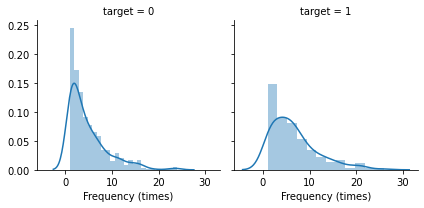

In [28]:
#F (Frequency - total number of donation)

fig = plt.figure(figsize=(8,6))
g = sns.FacetGrid(df, col='target')
g.map(sns.distplot, "Frequency (times)")
plt.show()

**Total number of donation** - 
 - distributions are not the same
 - peak corresponding to the people who have donated only 0-1 time will not donate blood and who have donated 2-3 will likely donate.
 - It seems that people have donated more number of times are more likely to donate blood.

<Figure size 576x432 with 0 Axes>

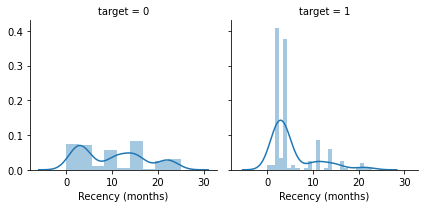

In [29]:
# R (Recency - months since the last donation)

fig = plt.figure(figsize=(8,6))
g = sns.FacetGrid(df, col='target')
g.map(sns.distplot, "Recency (months)")
plt.show()

**Months since the last donation**
 - distributions are not the same.
 - peak corresponding to the people who have donated recently(in 1-2 months) will donate blood.
 - It seems that people have donated recently are more likely to donate blood.

<Figure size 576x432 with 0 Axes>

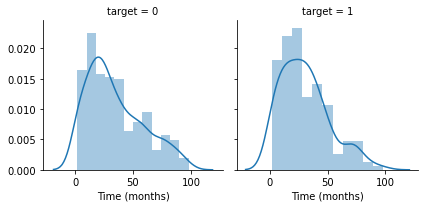

In [30]:
# T (Time - months since the first donation)

fig = plt.figure(figsize=(8,6))
g = sns.FacetGrid(df, col='target')
g.map(sns.distplot, "Time (months)")
plt.show()

**Months since the first donation**
 - distributions are not the same 
 - peak corresponding to the people who have just donated recently(in 5-25 months) will not donate blood.

<Figure size 576x432 with 0 Axes>

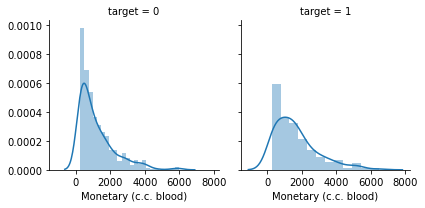

In [31]:
# M (Monetary - total blood donated in c.c.)

fig = plt.figure(figsize=(8,6))
g = sns.FacetGrid(df, col='target')
g.map(sns.distplot, "Monetary (c.c. blood)")
plt.show()

**Volume Donated**
 - Can observe as Volume of donation i.e. cc increasing, chances of donating again slightly increase

In [32]:
X_Data = df.drop(columns='target')
X_Data.head(2)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months)
1,0,13,3250,28
2,1,16,4000,35


In [33]:
Y_Data = df.target
Y_Data.head(2)

1    1
2    1
Name: target, dtype: int64

### Splitting dataframe into train and test datasets

In [34]:
# Split df DataFrame into
# X_train, X_test, y_train and y_test datasets,
# stratifying on the 'target' column
# As We want to keep the same structure in train and test datasets, i.e., both datasets must have 0 target incidence of 76%

X_train, X_test, y_train, y_test = train_test_split(X_Data,Y_Data,test_size=0.3,random_state=0,stratify=df.target)

In [35]:
X_train.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months)
729,23,3,750,39
584,2,1,250,2
369,16,5,1250,40
461,21,1,250,21
258,4,3,750,28


### Selecting model using TPOT

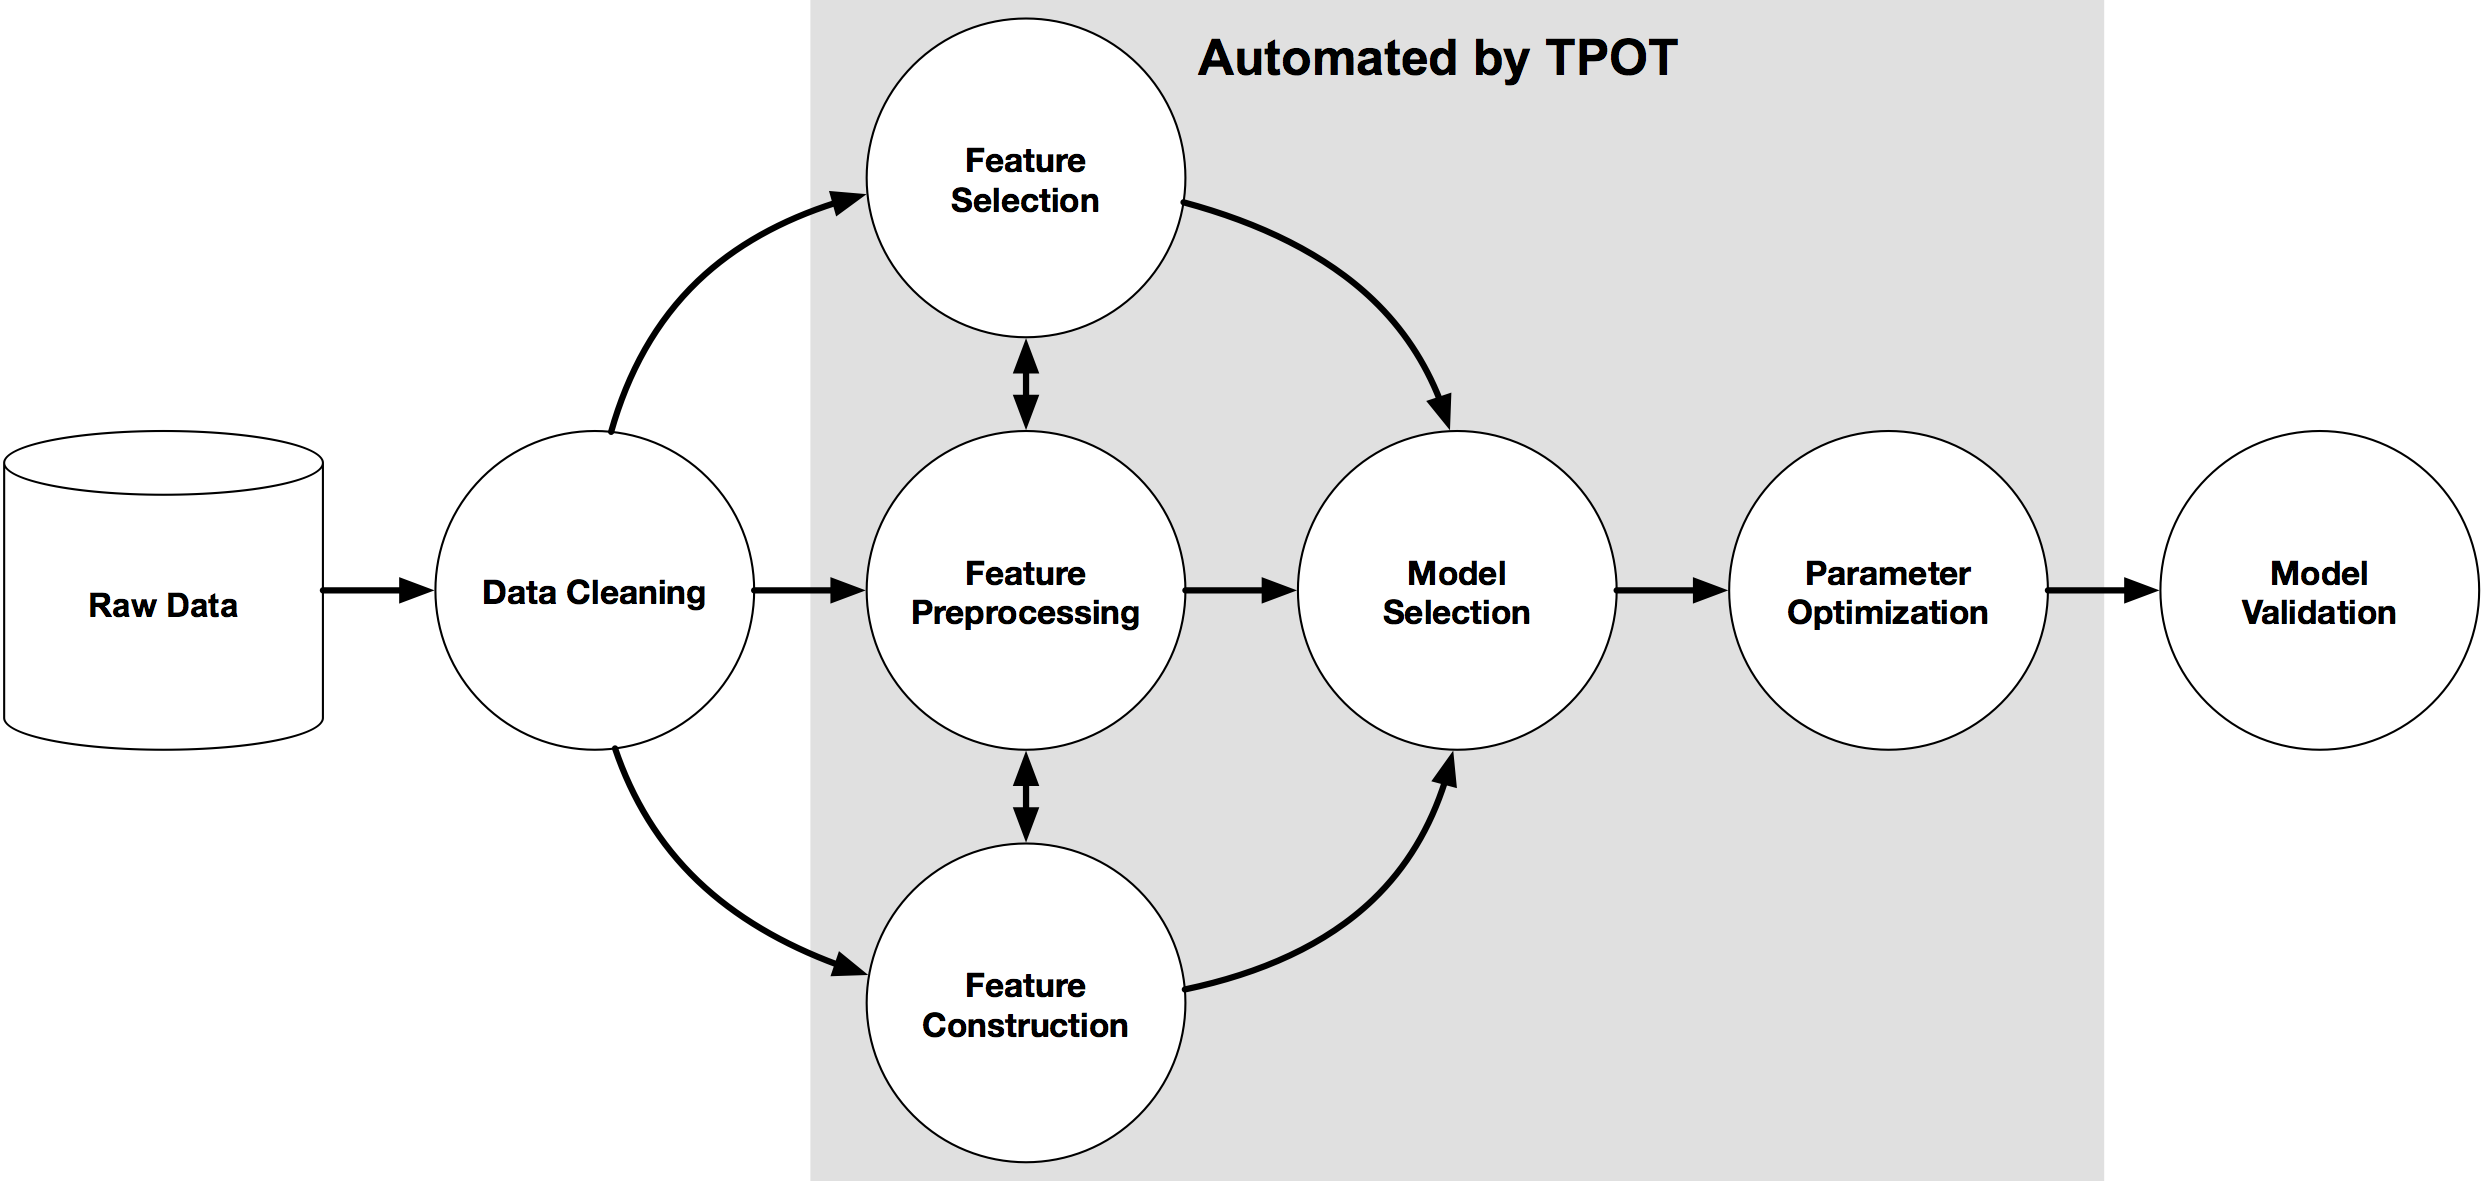

In [36]:
# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5, #number of iterations to run ; pipeline optimisation process ; by default value is 100
    population_size=20, #number of individuals to retrain in the genetic programing popluation in every generation, by default value is 100
    verbosity=2, #it will state how much info TPOT will communicate while it is running
    scoring='roc_auc', #use to evaluate the quality of given pipeline
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)

# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')


Generation 1 - Current best internal CV score: 0.7501994752785892

Generation 2 - Current best internal CV score: 0.7501994752785892

Generation 3 - Current best internal CV score: 0.7501994752785892

Generation 4 - Current best internal CV score: 0.7501994752785892

Generation 5 - Current best internal CV score: 0.7516559829059829

Best pipeline: LogisticRegression(Normalizer(MaxAbsScaler(input_matrix), norm=l2), C=25.0, dual=False, penalty=l2)

AUC score: 0.7290

Best pipeline steps:
1. MaxAbsScaler()
2. Normalizer()
3. LogisticRegression(C=25.0, random_state=42)


In [37]:
tpot.fitted_pipeline_

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('normalizer', Normalizer()),
                ('logisticregression',
                 LogisticRegression(C=25.0, random_state=42))])

###  Log normalization

In [38]:
# normalize the column
col_norm = ["Monetary (c.c. blood)"]

# Copy X_train and X_test into X_train_normed and X_test_normed
X_train_normed, X_test_normed = X_train.copy(), X_test.copy()

# Log normalization
for df_norm in [X_train_normed, X_test_normed]:
    # Add log normalized column
    df_norm['log_monetary'] = np.log(df_norm[col_norm])
    # Drop the original column
    df_norm.drop(columns=col_norm, inplace=True)

In [39]:
# Comparing the values for X_train and X_train_normed
print("X_train Value\n")
print(X_train.head())
print("------------------------")
print("X_train_normed Value\n")
print(X_train_normed.head())

X_train Value

     Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)
729                23                  3                    750             39
584                 2                  1                    250              2
369                16                  5                   1250             40
461                21                  1                    250             21
258                 4                  3                    750             28
------------------------
X_train_normed Value

     Recency (months)  Frequency (times)  Time (months)  log_monetary
729                23                  3             39      6.620073
584                 2                  1              2      5.521461
369                16                  5             40      7.130899
461                21                  1             21      5.521461
258                 4                  3             28      6.620073


In [40]:
# Comparing the variance for X_train and X_train_normed
print("X_train Variance\n")
print(X_train.var().round(2))
print("------------------------")
print("X_train_normed Variance\n")
print(X_train_normed.var().round(2))

X_train Variance

Recency (months)              49.46
Frequency (times)             20.88
Monetary (c.c. blood)    1304826.77
Time (months)                591.75
dtype: float64
------------------------
X_train_normed Variance

Recency (months)      49.46
Frequency (times)     20.88
Time (months)        591.75
log_monetary           0.79
dtype: float64


### Training the linear regression model

In [41]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=25.0, random_state=42)
# Train the model
logreg.fit(X_train_normed, y_train)

LogisticRegression(C=25.0, random_state=42)

In [42]:
# AUC score for tpot model
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test_normed)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.7496


In [43]:
# Importing itemgetter
from operator import itemgetter

# Sort models based on their AUC score from highest to lowest
sorted(
    [('tpot', tpot_auc_score), ('logreg', logreg_auc_score)],
    key=itemgetter(1),
    reverse=True)

[('logreg', 0.7495649147232858), ('tpot', 0.7290288896623738)]

### Saving the prediction

In [44]:
#predicting on the test data
prediction = logreg.predict(X_test)

In [45]:
#Confusion matrix
confusion_matrix(prediction,y_test)

array([[134,  46],
       [ 35,   5]], dtype=int64)

In [46]:
pred_report = pd.DataFrame(prediction.tolist(),columns=["Made Donation in March 2007"])
# saving the prediction
pred_report.to_csv("final_submission.csv")

### Modeling

In [47]:
import pickle

# Saving model to disk
pickle.dump(logreg, open('model.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model.pkl', 'rb'))
print(model.predict([[9, 3, 750, 52]]))

[1]
